# Imports

In [1]:
from pathlib import Path
import json

import pandas as pd
pd.options.display.max_columns = 512
import matplotlib.pyplot as plt

# Load data

In [2]:
results = list()
for elem in Path("src/results").glob("*.json"):
    with open(elem, "r") as f:
        results.append(json.load(f))

In [3]:
df = pd.json_normalize(results)
df.shape

(9720, 10)

### Validate number of executions

In [4]:
(
    df
    .groupby(["dataset", "model", "neurons"])
    .agg({"neurons": "count"})
    .rename(columns={"neurons": "executions"})
    .mean()
)

executions    30.0
dtype: float64

In [5]:
(
    df
    .groupby(["dataset", "model", "neurons"], as_index=False)
    .agg({"evaluation.acc_test": "mean"})
    .sort_values(["neurons", "model"])
    .pivot(index="dataset", columns=["model", "neurons"], values="evaluation.acc_test")
)

model,ELM,ELMPCA,ELMReg,ELM,ELMPCA,ELMReg,ELM,ELMPCA,ELMReg,ELM,ELMPCA,ELMReg,ELM,ELMPCA,ELMReg,ELM,ELMPCA,ELMReg,ELM,ELMPCA,ELMReg,ELM,ELMPCA,ELMReg,ELM,ELMPCA,ELMReg
neurons,4,4,4,8,8,8,16,16,16,32,32,32,64,64,64,128,128,128,256,256,256,512,512,512,1024,1024,1024
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,
banknote,0.951942,0.907686,0.838754,0.976214,0.973058,0.853236,0.986246,0.984223,0.913592,0.996036,0.987621,0.937621,0.999757,0.987540,0.961489,0.999353,0.983495,0.972168,0.999191,0.975971,0.976133,0.992233,0.974029,0.979045,0.906715,0.968608,0.979126
breast_coimbra,0.638095,0.593333,0.571429,0.644762,0.656190,0.592381,0.660952,0.655238,0.558095,0.634286,0.652381,0.600000,0.563810,0.659048,0.604762,0.539048,0.646667,0.617143,0.572381,0.646667,0.603810,0.596190,0.633333,0.637143,0.609524,0.644762,0.670476
breast_wiscons,0.969919,0.971870,0.972358,0.970732,0.974634,0.970732,0.973659,0.974959,0.974959,0.966016,0.972520,0.976098,0.960163,0.973008,0.972846,0.937398,0.969919,0.976911,0.866179,0.969919,0.976423,0.896585,0.972683,0.977073,0.914472,0.971707,0.971382
cred_aus,0.757005,0.745733,0.746377,0.789855,0.761675,0.748631,0.800161,0.795974,0.768438,0.823671,0.813849,0.771981,0.822544,0.811272,0.793237,0.810306,0.820612,0.803865,0.756683,0.791626,0.823833,0.537359,0.788889,0.830596,0.603543,0.804187,0.834944
cred_ger,0.700333,0.699556,0.699889,0.698000,0.697889,0.700556,0.699222,0.694111,0.695444,0.700667,0.702667,0.687778,0.716222,0.711778,0.700222,0.693889,0.702444,0.715333,0.665444,0.681778,0.721667,0.592333,0.657000,0.730667,0.505667,0.644222,0.739000
haberman_surv,0.740217,0.743116,0.739130,0.744565,0.739130,0.739130,0.727899,0.752174,0.739130,0.726449,0.747464,0.738768,0.700000,0.747101,0.738043,0.660507,0.750000,0.736957,0.567391,0.744928,0.742391,0.558333,0.734058,0.738043,0.552174,0.736594,0.748551
heart,0.770782,0.743621,0.741564,0.779835,0.770370,0.746502,0.795885,0.783951,0.748148,0.797531,0.791770,0.748148,0.772428,0.782716,0.753909,0.692593,0.765844,0.780247,0.662551,0.762963,0.798765,0.739918,0.769959,0.788066,0.751852,0.770782,0.802469
ilpd,NaN,NaN,NaN,NaN,NaN,0.680000,NaN,0.714286,NaN,0.708571,NaN,0.691429,0.714286,NaN,NaN,NaN,0.680000,NaN,NaN,0.702857,NaN,NaN,NaN,0.697143,NaN,NaN,NaN


# Plot scatter of all executions

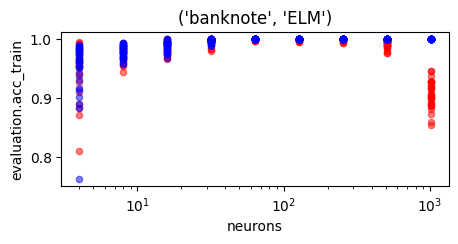

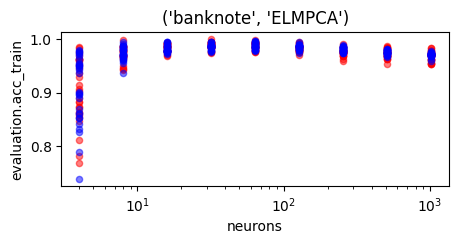

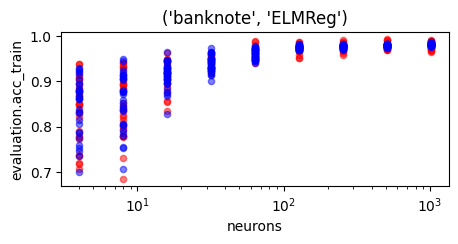

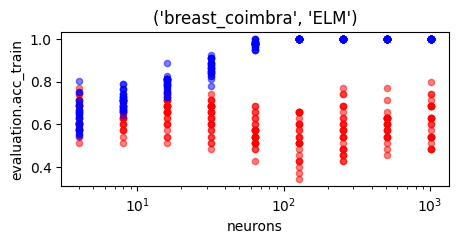

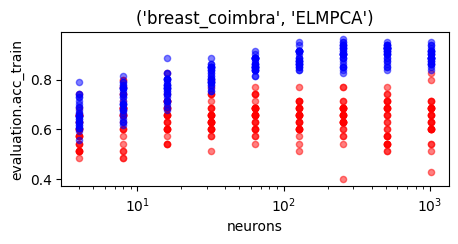

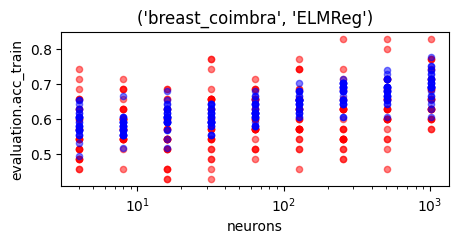

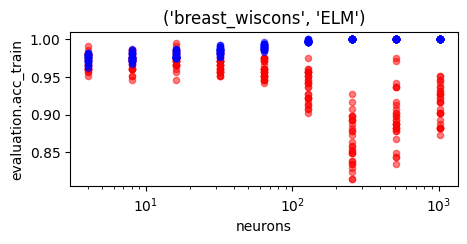

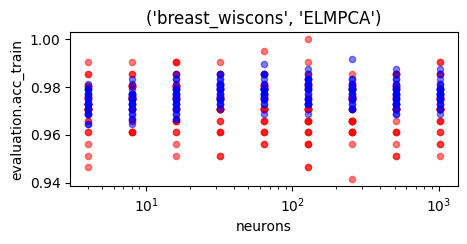

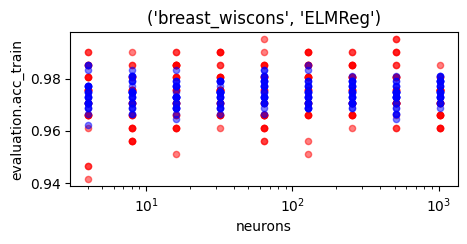

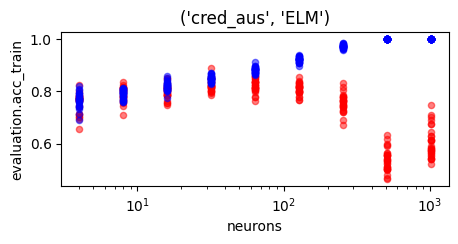

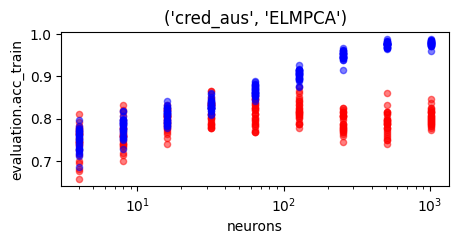

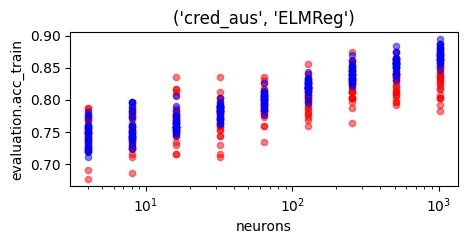

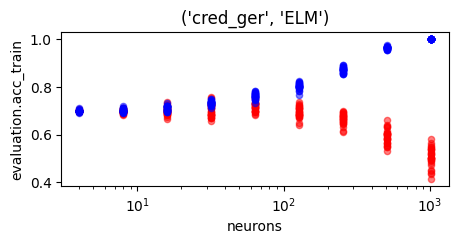

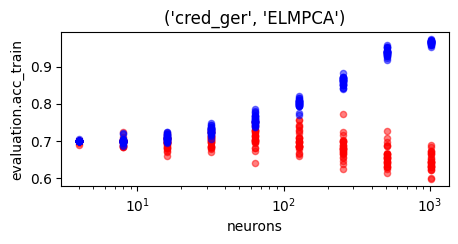

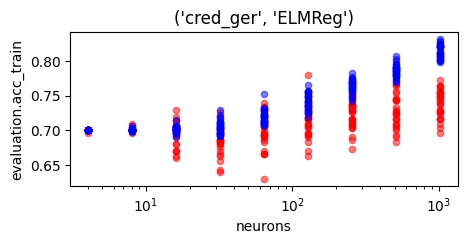

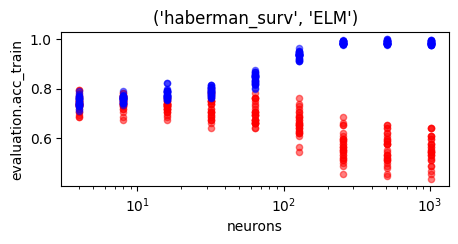

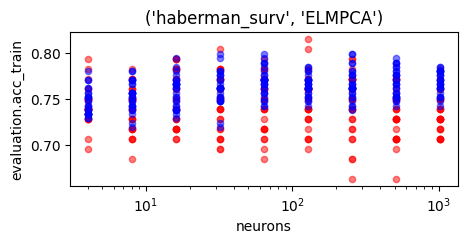

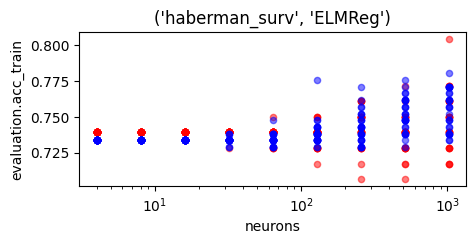

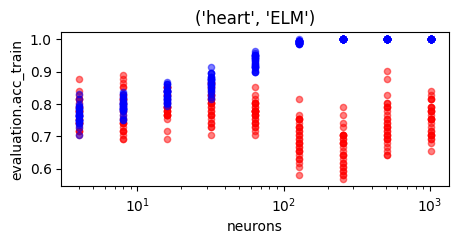

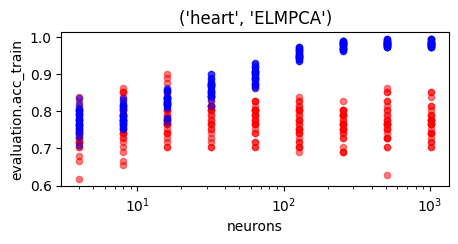

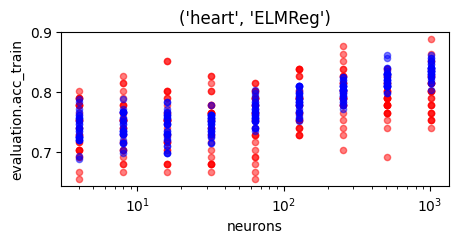

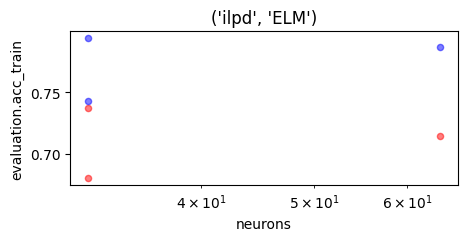

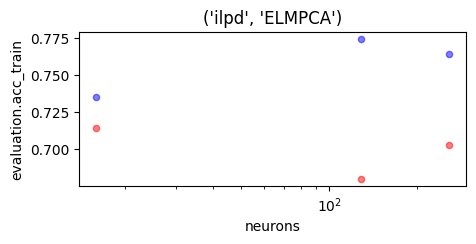

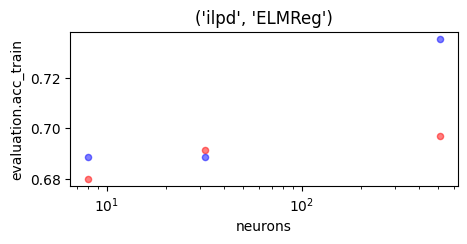

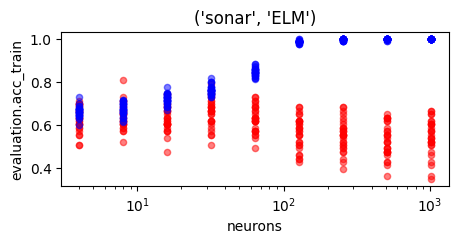

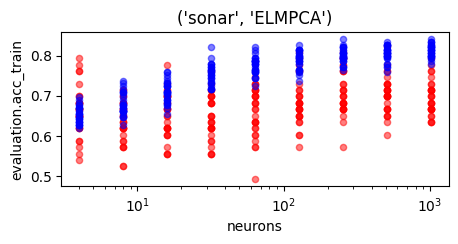

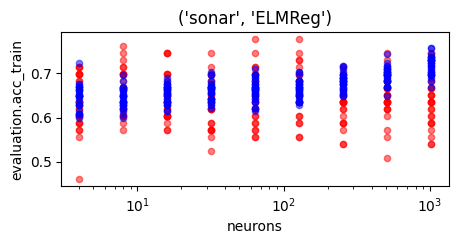

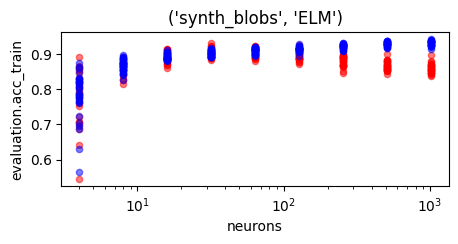

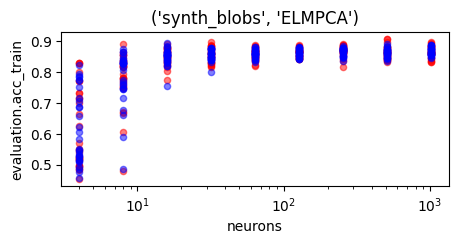

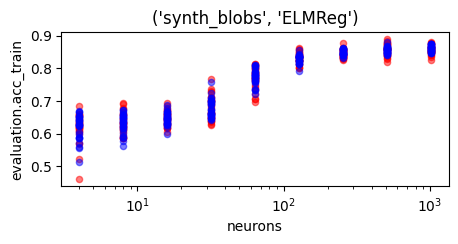

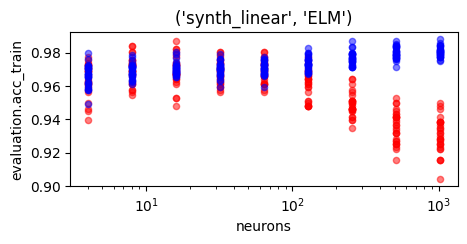

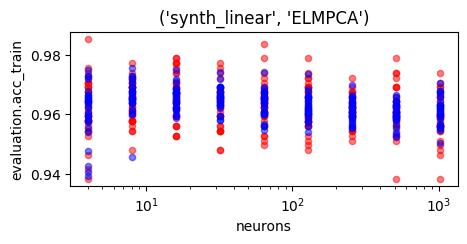

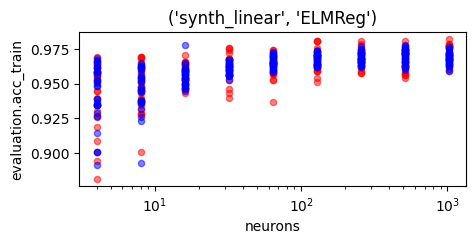

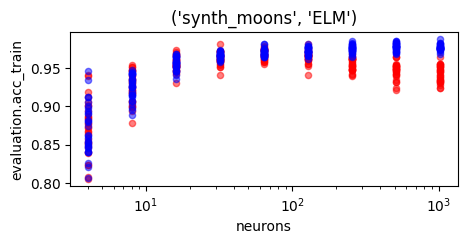

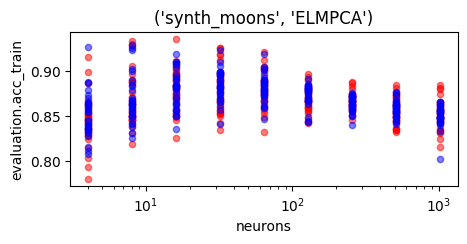

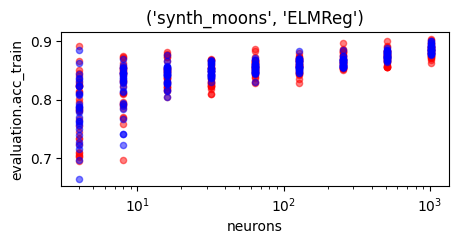

In [6]:
for name, group in df.groupby(["dataset", "model"]):
    plt.figure(figsize=(5, 2))
    ax = plt.gca()
    group.plot.scatter(
        x="neurons", y="evaluation.acc_test",
        color="red", alpha=.5, ax=ax,
    )
    group.plot.scatter(
        x="neurons", y="evaluation.acc_train",
        color="blue", alpha=.5, ax=ax,
    )
    plt.xscale("log")
    plt.title(name)
    plt.show()
    plt.close()

# Plot average metrics

In [24]:
means = (
    df
    .groupby(["dataset", "model", "neurons"], as_index=False)
    .agg({
        "evaluation.acc_train": "mean",
        "evaluation.acc_test": "mean",
        "evaluation.time_to_fit": "mean",
    })
)

means["evaluation.acc_diff"] = means["evaluation.acc_test"] - means["evaluation.acc_train"]

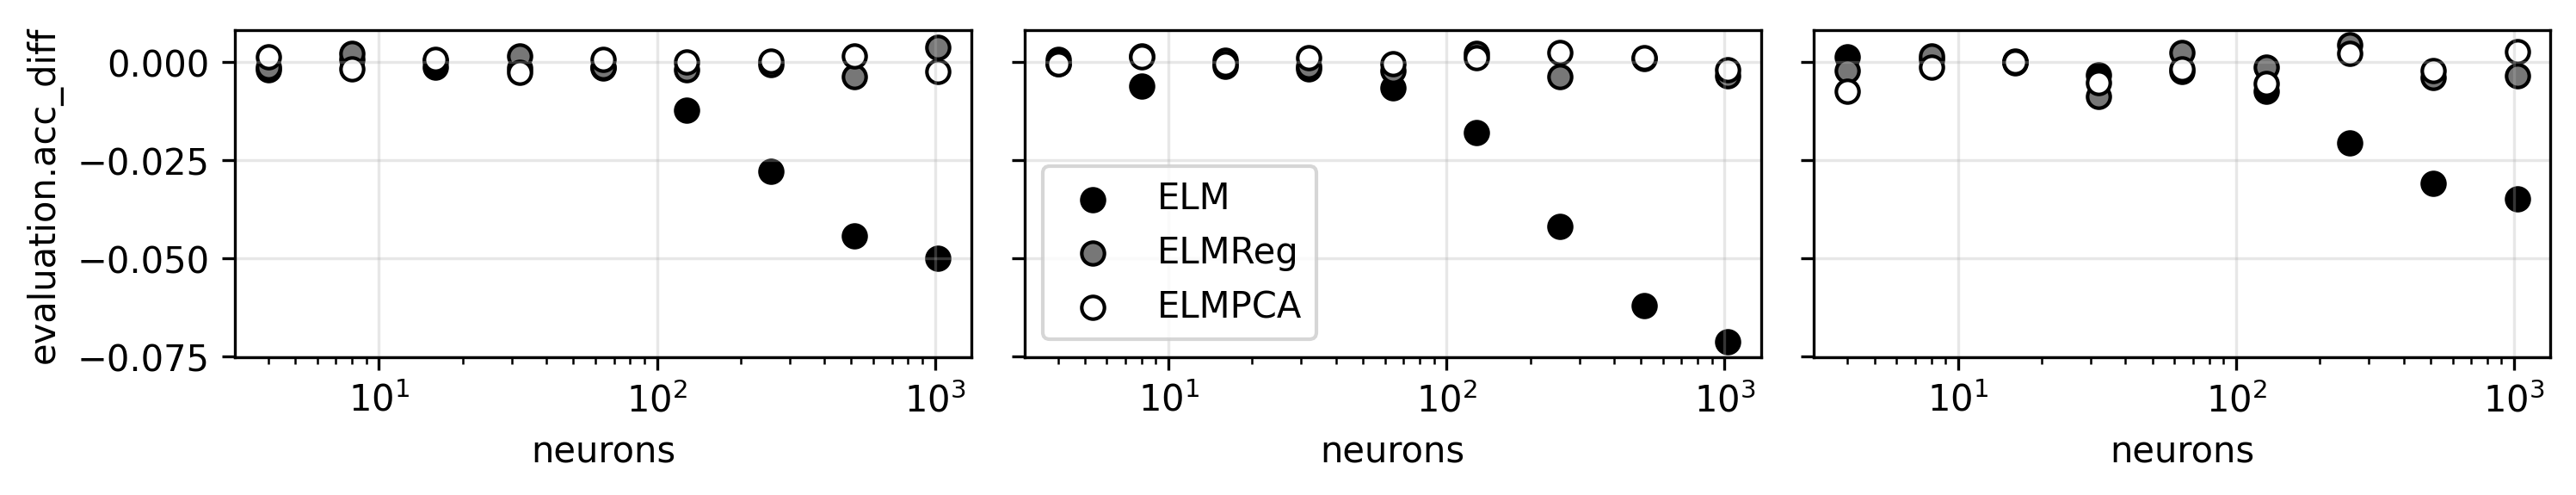

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(10, 2), dpi=300, sharex=True, sharey=True)

for i, dataset in enumerate(["synth_linear", "synth_blobs", "synth_moons"]):
    for (model, color) in [("ELM", "#000000"), ("ELMReg", "#777777"), ("ELMPCA", "#FFFFFF")]:
        aux = means[
            (means["dataset"] == dataset)
            & (means["model"] == model)
        ]

        aux.plot.scatter(x="neurons", y="evaluation.acc_diff", color=color, edgecolors="black", ax=ax[i], s=40, label=model)
        ax[i].grid(alpha=.3)
        ax[i].get_legend().remove()

ax[1].legend()
plt.xscale("log")
plt.tight_layout()
plt.savefig("metrics.pdf")

# Pivot metrics

In [28]:
means[means["neurons"] == 1024].round(3)[[
    "dataset", "model",
    "evaluation.acc_train", "evaluation.acc_test", "evaluation.acc_diff", "evaluation.time_to_fit"
]]

,dataset,model,evaluation.acc_train,evaluation.acc_test,evaluation.acc_diff,evaluation.time_to_fit
8,banknote,ELM,1.000,0.907,-0.093,0.467
17,banknote,ELMPCA,0.971,0.969,-0.002,3.609
26,banknote,ELMReg,0.981,0.979,-0.002,0.539
35,breast_coimbra,ELM,1.000,0.610,-0.390,0.016
44,breast_coimbra,ELMPCA,0.894,0.645,-0.249,2.988
53,breast_coimbra,ELMReg,0.699,0.670,-0.029,0.424
62,breast_wiscons,ELM,1.000,0.914,-0.086,0.175
71,breast_wiscons,ELMPCA,0.977,0.972,-0.005,3.151
80,breast_wiscons,ELMReg,0.976,0.971,-0.004,0.432
89,cred_aus,ELM,1.000,0.604,-0.396,0.218


In [29]:
means[means["neurons"] == 32].round(3)[[
    "dataset", "model",
    "evaluation.acc_train", "evaluation.acc_test", "evaluation.acc_diff", "evaluation.time_to_fit"
]]

,dataset,model,evaluation.acc_train,evaluation.acc_test,evaluation.acc_diff,evaluation.time_to_fit
3,banknote,ELM,0.997,0.996,-0.001,0.003
12,banknote,ELMPCA,0.986,0.988,0.001,0.008
21,banknote,ELMReg,0.940,0.938,-0.003,0.003
30,breast_coimbra,ELM,0.867,0.634,-0.233,0.001
39,breast_coimbra,ELMPCA,0.817,0.652,-0.165,0.002
48,breast_coimbra,ELMReg,0.603,0.600,-0.003,0.001
57,breast_wiscons,ELM,0.985,0.966,-0.019,0.003
66,breast_wiscons,ELMPCA,0.978,0.973,-0.006,0.004
75,breast_wiscons,ELMReg,0.974,0.976,0.002,0.003
84,cred_aus,ELM,0.850,0.824,-0.026,0.003


# Compare `ELMReg` with `ELMPCA`

In [30]:
cmp = means.pivot(columns="model", index=["dataset", "neurons"], values=["evaluation.acc_test"])
cmp

evaluation.acc_test                    
model                               ELM    ELMPCA    ELMReg
dataset     neurons                                        
banknote    4                  0.951942  0.907686  0.838754
            8                  0.976214  0.973058  0.853236
            16                 0.986246  0.984223  0.913592
            32                 0.996036  0.987621  0.937621
            64                 0.999757  0.987540  0.961489
...                                 ...       ...       ...
synth_moons 64                 0.968347  0.879946  0.856531
            128                0.965474  0.868130  0.858699
            256                0.955285  0.866450  0.868401
            512                0.947154  0.856314  0.872520
            1024               0.942602  0.852900  0.883848

[108 rows x 3 columns]

---